#### Prepared for Gabor's Data Analysis

# Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

# Chapter 17

## Predicting firm exit

In [151]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [152]:
# Current script folder
path = os.getcwd()
base_dir = path.split("da_case_studies")[0]

# Set the location of your data directory
data_dir = base_dir + "da_data_repo"

# location folders
data_in = os.path.join(data_dir, "bisnode-firms/clean/")
data_out = os.path.join(data_dir, "bisnode-firms/")
output = os.path.join(data_out, "output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")
sys.path.append(func)

# Import the prewritten helper functions
import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

## Import data

In [153]:
# !!! make sure you have run ch17-firm-exit-data-prep.ipynb before
data = pd.read_csv(data_out + "bisnode_firms_clean.csv")

In [154]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,19036.0,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000,19036.000000,19036.000000,19036.000000
mean,2012.0,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,...,0.004150,0.145619,0.267388,0.627548,0.135900,1.225573e+01,0.038926,0.021538,-0.048296,0.287703
std,0.0,1.377319e+11,4.975021e+04,4.377075e+05,4.202974e+05,7141.930068,3.283540e+04,3.212567e+04,1.105861e+06,1.305634e+05,...,0.064289,0.352733,0.442608,1.473032,0.342692,1.042676e+01,0.193424,0.145174,0.534214,0.602235
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000
25%,2012.0,2.868348e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.519444e+03,...,0.000000,0.000000,0.000000,0.125000,0.000000,4.049695e+00,0.000000,0.000000,-0.194249,0.000654
50%,2012.0,1.142688e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.407407e+02,...,0.000000,0.000000,0.000000,0.291667,0.000000,9.767982e+00,0.000000,0.000000,0.000000,0.025531
75%,2012.0,2.556061e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.066667e+03,...,0.000000,0.000000,1.000000,0.621691,0.000000,1.754330e+01,0.000000,0.000000,0.130772,0.188141
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [155]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    # Plot loss curve
    sns.lineplot(x=all_coords_copy["thresholds"], y=all_coords_copy["loss"])

    # Vertical line for optimal threshold
    plt.axvline(x=t, linestyle="--")

    # Annotations
    plt.text(
        t - 0.03,
        all_coords_copy["loss"].max() - 0.7,
        f"Best threshold: {round(t, 2)}",
        color=da.color[1],
        rotation=90,
        fontsize=8,
    )
    plt.text(t + 0.06, l, f"{round(l, 2)}", fontsize=8)

    # Labels and limits
    plt.xlabel("Thresholds")
    plt.ylabel("Expected loss")
    plt.xlim(-0.01, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Style
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    sns.lineplot(x=fpr, y=tpr, linewidth=1)

    # Fill area under curve
    plt.fill_between(fpr, tpr, alpha=0.3, color="mediumaquamarine")

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    # Plot ROC curve
    sns.lineplot(x=all_coords_copy["sp"], y=all_coords_copy["se"])

    # Highlight optimal threshold point
    plt.scatter(sp, se, color="black", s=10)
    plt.text(sp, se + 0.03, f"{round(sp, 2)}, {round(se, 2)}", fontsize=10, ha="center")

    # Fill area under curve
    plt.fill_between(
        all_coords_copy["sp"],
        all_coords_copy["se"],
        alpha=0.3,
        color="mediumaquamarine",
    )

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], linestyle="dotted", color="black", linewidth=0.9)

    # Labels and limits
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.xlim(0, 1.01)
    plt.ylim(0, 1.01)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Style
    sns.despine()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.show()

## Model building

### Define variable sets 

 Main firm variables

In [156]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [157]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [158]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [159]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [160]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [161]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [162]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [163]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [164]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [165]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [166]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     185.4
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:10:42   Log-Likelihood:                -7998.3
No. Observations:               19036   AIC:                         1.603e+04
Df Residuals:                   19017   BIC:                         1.618e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1495      0.014     10.540      0.000       0.122       0.177
C(ind2_cat)[T.27.0]         0.0175      0.015      1.141      0.254      -0.013       0.048
C(ind2_cat)[T.28.0]         0.0086      0.012      0.751      0.452      -0.014       0.031
C(ind2_cat)[T.29.0]         0.0438      0.022      1.977      0.048       0.000       0.087
C(ind2_cat)[T.30.0]        -0.0045      0.031     -0.146      0.884      -0.065       0.056
C(ind2_cat)[T.33.0]        -0.0153      0.012     -1.293      0.196      -0.038       0.008
C(ind2_cat)[T.55.0]         0.0169      0.013      1.328      0.184      -0.008       0.042
C(ind2_cat)[T.56.0]         0.0579      0.011      5.386      0.000       0.037       0.079
sales_mil_log               0.0064      0.003      1.932      0.053   -9.28e-05       0.013
sales_mil_log_sq            0.0069      0.001     10.671      0.000       0.006       0.008
d1_sales_mil_log_mod       -0.0704      0.006    -11.435      0.000      -0.082      -0.058
profit_loss_year_pl        -0.0991      0.011     -9.094      0.000      -0.120      -0.078
fixed_assets_bs            -0.1197      0.009    -13.165      0.000      -0.138      -0.102
share_eq_bs                -0.0586      0.007     -7.895      0.000      -0.073      -0.044
curr_liab_bs               -0.0027      0.012     -0.220      0.826      -0.026       0.021
curr_liab_bs_flag_high      0.0509      0.011      4.478      0.000       0.029       0.073
curr_liab_bs_flag_error     0.0281      0.134      0.210      0.834      -0.234       0.291
age                        -0.0043      0.000    -10.272      0.000      -0.005      -0.003
foreign_management          0.0205      0.009      2.288      0.022       0.003       0.038
==============================================================================
Omnibus:                     2861.598   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4351.661
Skew:                           1.161   Prob(JB):                         0.00
Kurtosis:                       3.315   Cond. No.                         826.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [167]:
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.423258
         Iterations 7


In [168]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                19036
Model:                          Logit   Df Residuals:                    19017
Method:                           MLE   Df Model:                           18
Date:                Sat, 08 Feb 2025   Pseudo R-squ.:                  0.1591
Time:                        15:10:43   Log-Likelihood:                -8057.1
converged:                       True   LL-Null:                       -9581.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.3506      0.148    -15.877      0.000      -2.641      -2.060
C(ind2_cat)[T.27.0]         0.1455      0.176      0.829      0.407      -0.199       0.490
C(ind2_cat)[T.28.0]         0.0327      0.137      0.238      0.812      -0.236       0.302
C(ind2_cat)[T.29.0]         0.4063      0.224      1.816      0.069      -0.032       0.845
C(ind2_cat)[T.30.0]        -0.0330      0.293     -0.113      0.910      -0.608       0.542
C(ind2_cat)[T.33.0]        -0.1578      0.136     -1.161      0.246      -0.424       0.109
C(ind2_cat)[T.55.0]         0.1287      0.131      0.985      0.324      -0.127       0.385
C(ind2_cat)[T.56.0]         0.4636      0.114      4.064      0.000       0.240       0.687
sales_mil_log              -0.1803      0.045     -4.020      0.000      -0.268      -0.092
sales_mil_log_sq            0.0153      0.006      2.459      0.014       0.003       0.027
d1_sales_mil_log_mod       -0.4821      0.038    -12.706      0.000      -0.556      -0.408
profit_loss_year_pl        -0.4501      0.059     -7.686      0.000      -0.565      -0.335
fixed_assets_bs            -0.8110      0.064    -12.631      0.000      -0.937      -0.685
share_eq_bs                -0.3881      0.046     -8.371      0.000      -0.479      -0.297
curr_liab_bs                0.1712      0.092      1.865      0.062      -0.009       0.351
curr_liab_bs_flag_high      0.1354      0.075      1.811      0.070      -0.011       0.282
curr_liab_bs_flag_error     0.3181      0.859      0.370      0.711      -1.366       2.003
age                        -0.0353      0.003    -10.474      0.000      -0.042      -0.029
foreign_management          0.2159      0.068      3.180      0.001       0.083       0.349
===========================================================================================
"""

With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [169]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]         0.0195      0.024      0.829      0.407      -0.027       0.066
C(ind2_cat)[T.28.0]         0.0044      0.018      0.238      0.812      -0.032       0.040
C(ind2_cat)[T.29.0]         0.0545      0.030      1.816      0.069      -0.004       0.113
C(ind2_cat)[T.30.0]        -0.0044      0.039     -0.113      0.910      -0.082       0.073
C(ind2_cat)[T.33.0]        -0.0212      0.018     -1.161      0.245      -0.057       0.015
C(ind2_cat)[T.55.0]         0.0173      0.018      0.985      0.324      -0.017       0.052
C(ind2_cat)[T.56.0]         0.0622      0.015      4.068      0.000       0.032       0.092
sales_mil_log              -0.0242      0.006     -4.015      0.000      -0.036      -0.012
sales_mil_log_sq            0.0021      0.001      2.464      0.014       0.000       0.004
d1_sales_mil_log_mod       -0.0646      0.005    -12.868      0.000      -0.074      -0.055
profit_loss_year_pl        -0.0603      0.008     -7.740      0.000      -0.076      -0.045
fixed_assets_bs            -0.1087      0.008    -12.793      0.000      -0.125      -0.092
share_eq_bs                -0.0520      0.006     -8.414      0.000      -0.064      -0.040
curr_liab_bs                0.0229      0.012      1.865      0.062      -0.001       0.047
curr_liab_bs_flag_high      0.0181      0.010      1.812      0.070      -0.001       0.038
curr_liab_bs_flag_error     0.0426      0.115      0.370      0.711      -0.183       0.269
age                        -0.0047      0.000    -10.545      0.000      -0.006      -0.004
foreign_management          0.0290      0.009      3.182      0.001       0.011       0.047
===========================================================================================
"""

## 0. Separate train and holdout data

In [170]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [171]:
print("Total")
print(data["default"].value_counts(normalize=True))
print("Train")
print(data_train["default"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["default"].value_counts(normalize=True))


Total
default
0    0.797857
1    0.202143
Name: proportion, dtype: float64
Train
default
0    0.799186
1    0.200814
Name: proportion, dtype: float64
Holdout
default
0    0.792542
1    0.207458
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [172]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [173]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [174]:
C_value_logit = [1e20]

In [175]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [176]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.372357,0.363849,0.361092,0.358717,0.358719
1,0.370867,0.363950,0.363286,0.360545,0.361303
2,0.373981,0.367897,0.368342,0.365429,0.366291
3,0.375318,0.364260,0.361899,0.358025,0.356924
4,0.378864,0.369600,0.366909,0.365220,0.365146


### b) Logit + LASSO

In [177]:
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [178]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [179]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [180]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [181]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.408111
1,0.046416,0.001768,0.378398
2,0.021544,0.003810,0.366064
3,0.010000,0.008209,0.362447
4,0.004642,0.017685,0.361294
5,0.002154,0.038101,0.361098
6,0.001000,0.082086,0.361286
7,0.000464,0.176848,0.361618
8,0.000215,0.381008,0.362029
9,0.000100,0.820856,0.362239


Save best lambda's index for later use

In [182]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [183]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [184]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [185]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [186]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [187]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

70

In [188]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

70

In [189]:
summary.round(3)

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.374,0.736
M2,19,0.366,0.770
M3,36,0.364,0.779
M4,80,0.362,0.785
M5,154,0.362,0.785
LASSO,70,0.361,0.786


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [190]:
best_logit = logit_models["M4"]
model_equation = "default~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [191]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["default"]), 3)

0.366

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


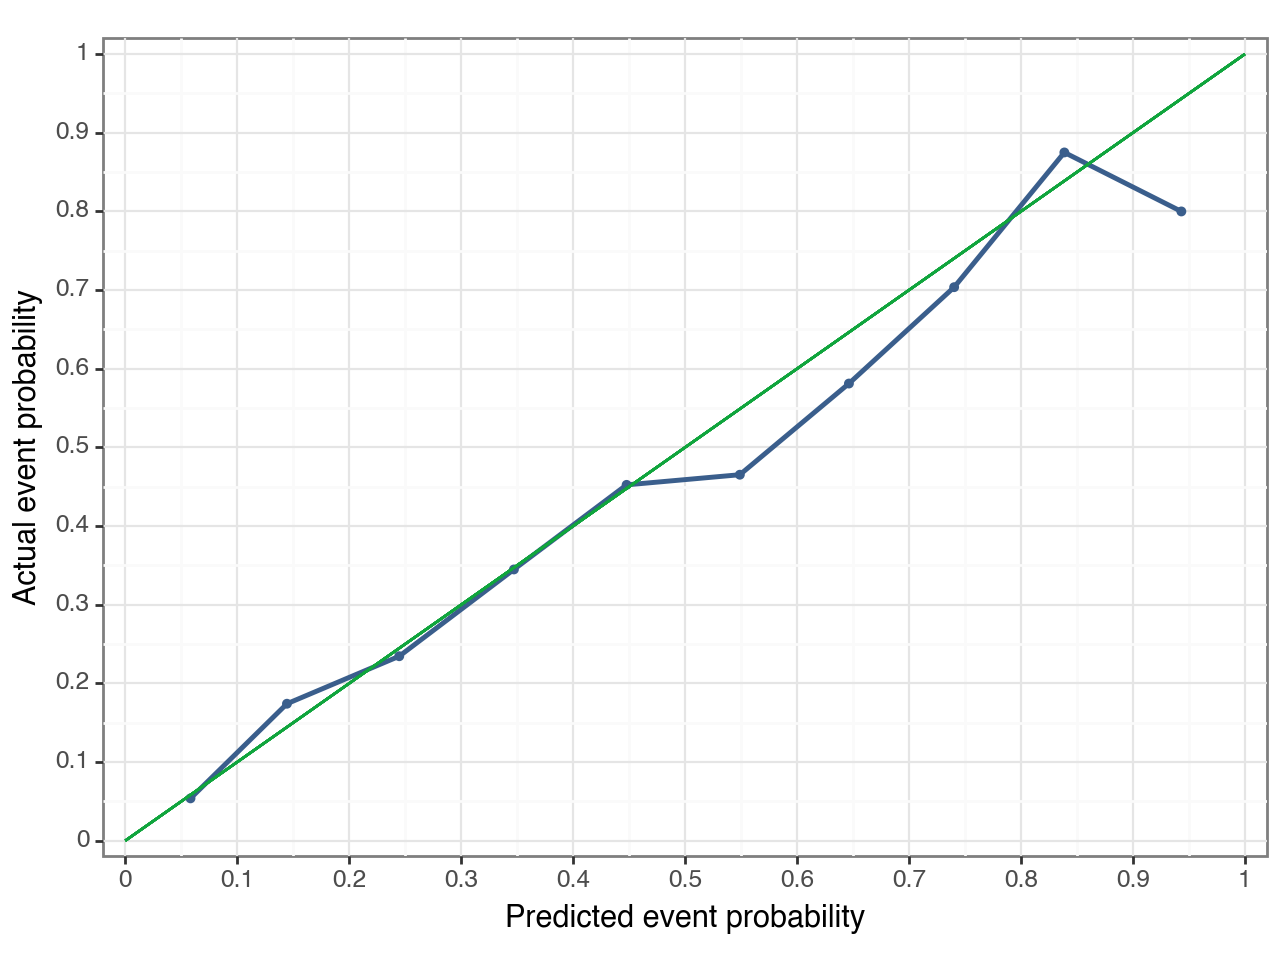

<Figure Size: (640 x 480)>

In [192]:
da.create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


### b) Confusion table with different tresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

In [193]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  3443
1.0  (default):  365


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [194]:
cm_object1 = confusion_matrix(
    data_holdout["default"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1

,Predicted no default,Predicted default
Actul no defaul,2869,149
Actual default,574,216


In [195]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1b

,Predicted no default,Predicted default
Actul no defaul,2869,149
Actual default,574,216


A sensible choice: mean of predicted probabilities

In [196]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.209

In [197]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["default"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm2

,Predicted no default,Predicted default
Actul no defaul,2175,843
Actual default,249,541


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [198]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["default"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [199]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

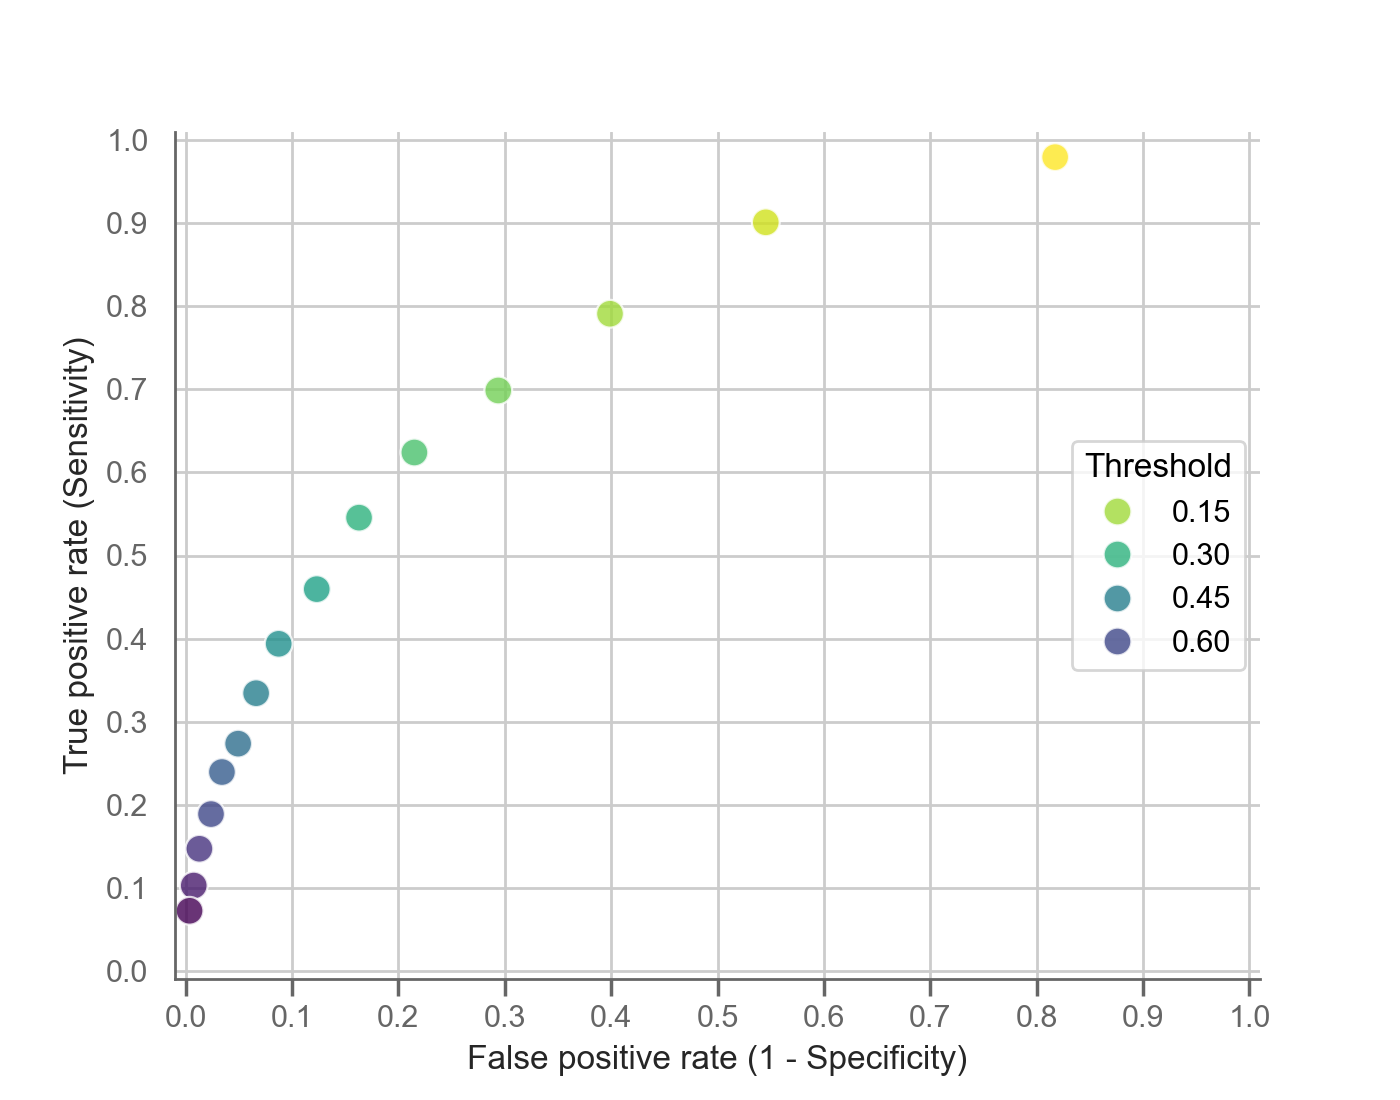

In [200]:
scatter = sns.scatterplot(
    data=tpr_fpr_for_thresholds,
    x="false_positive_rates",
    y="true_positive_rates",
    hue="thresholds",
    palette="viridis_r",
    s=100,
    alpha=0.8,
)

plt.xlabel("False positive rate (1 - Specificity)")
plt.ylabel("True positive rate (Sensitivity)")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0, 1.01, 0.1))
plt.legend(title="Threshold", loc="center right")
sns.despine()
plt.show()

Continuous ROC on holdout with best model

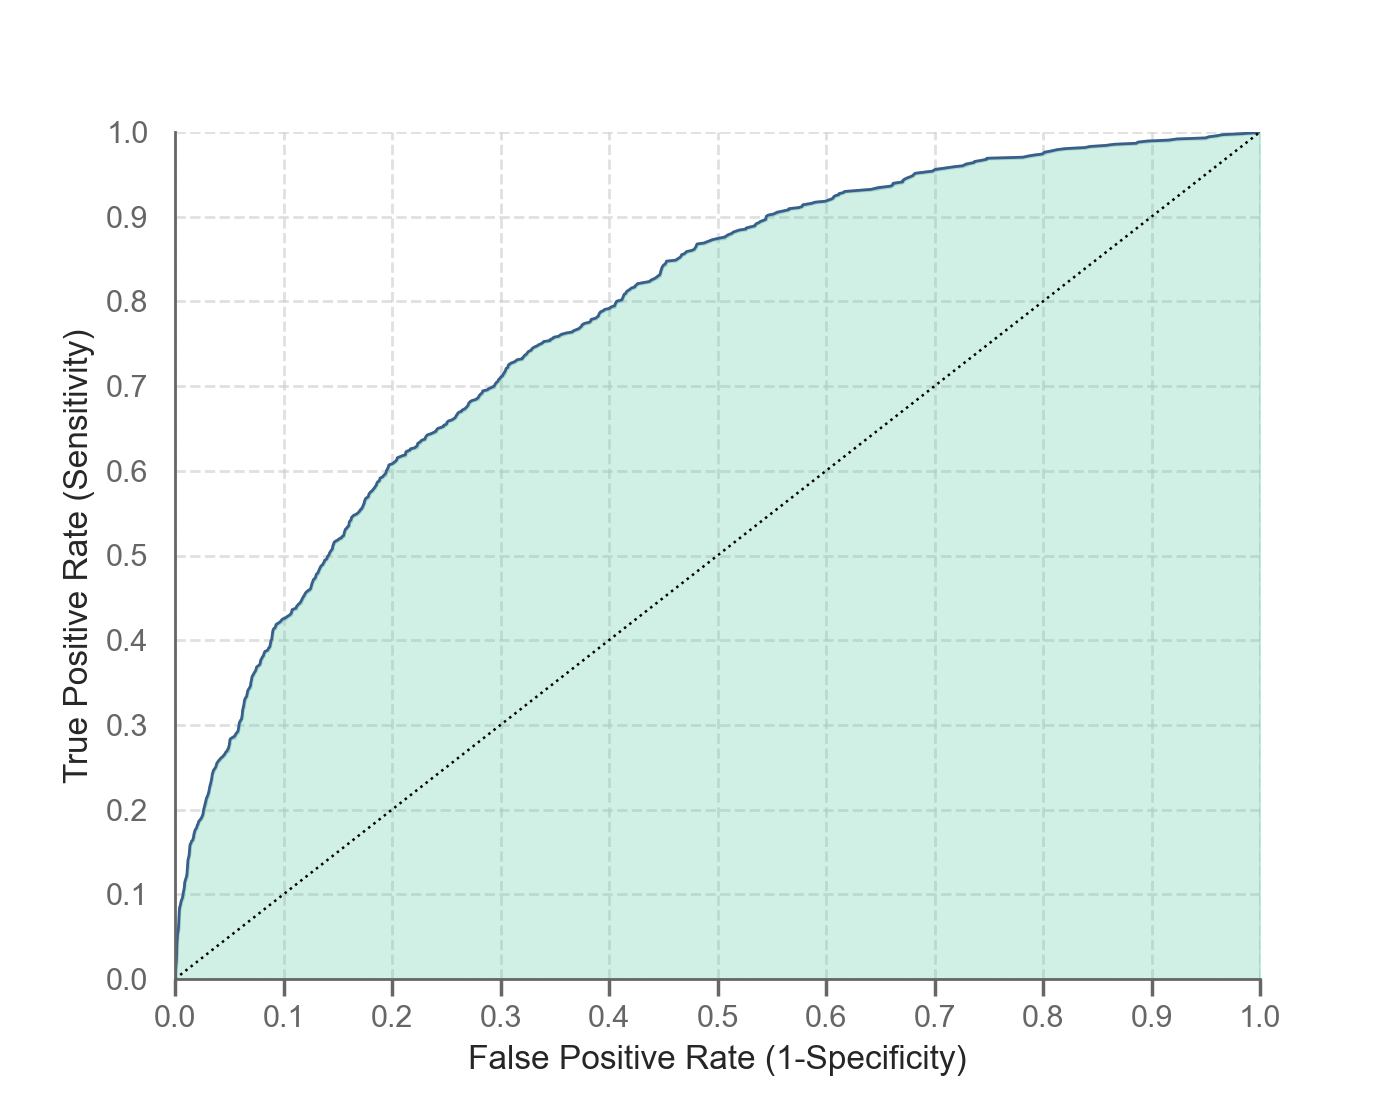

In [201]:
create_roc_plot(data_holdout["default"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [202]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [203]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [204]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [205]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [206]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.086296,0.099997,0.726753,0.716913
1,M2,0.093710,0.099004,0.657998,0.641051
2,M3,0.084222,0.102412,0.630351,0.617077
3,M4,0.088410,0.086194,0.622602,0.603284
4,M5,0.094016,0.098296,0.624835,0.626601
5,LASSO,0.095320,0.092476,0.620698,0.612808


Create loss plot based on Fold5 in CV 

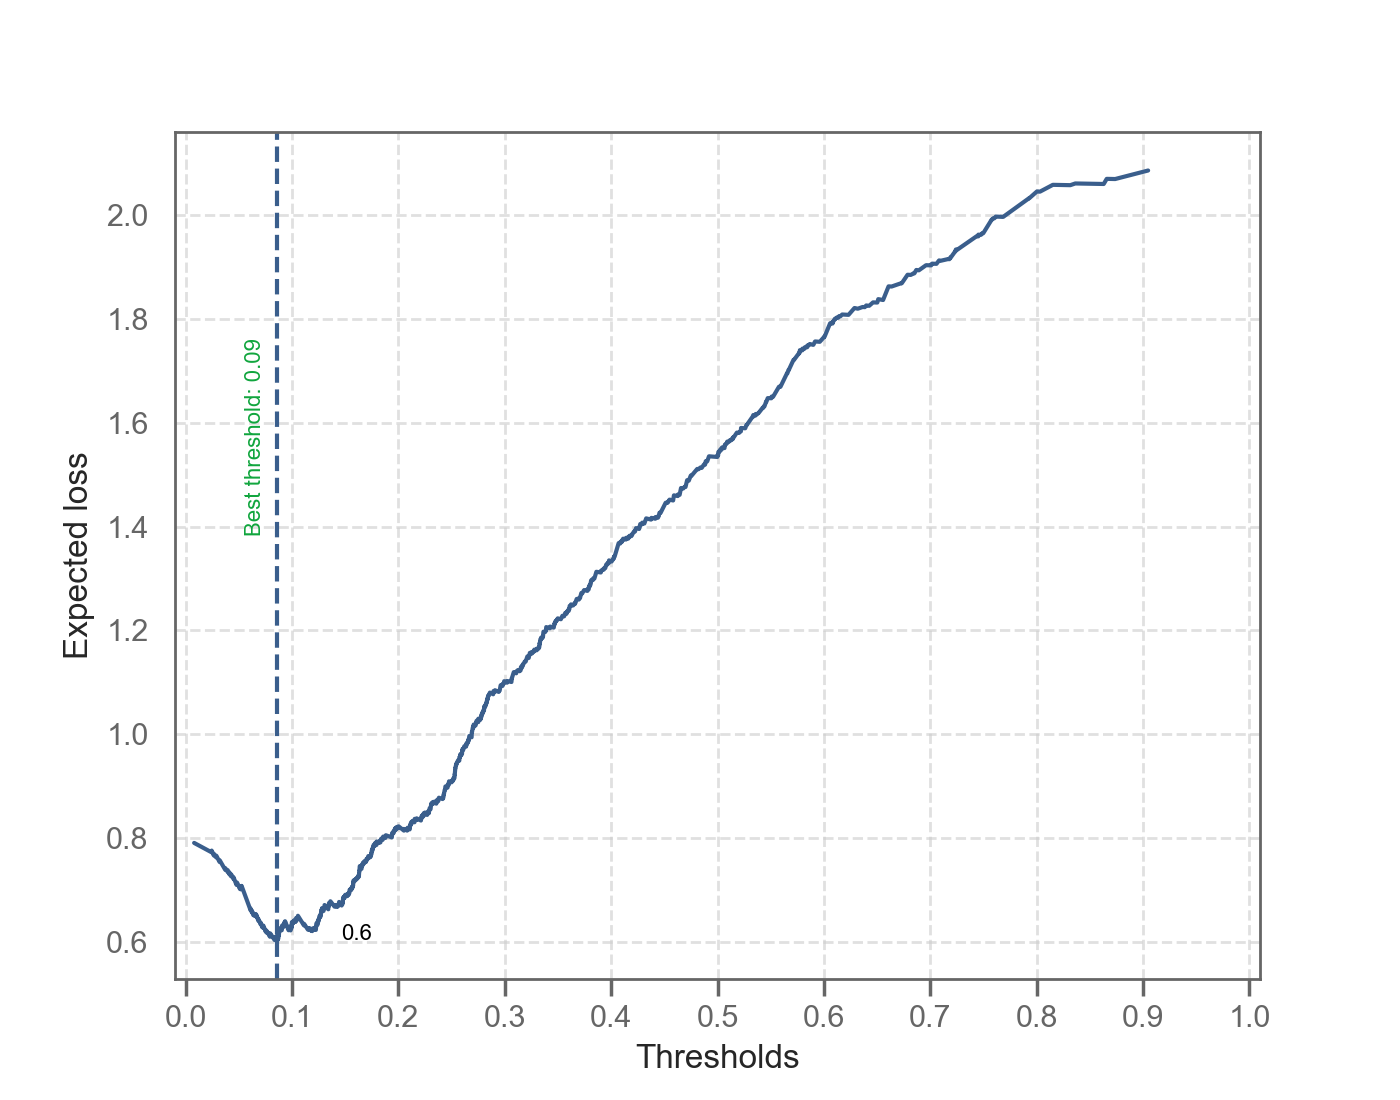

In [207]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

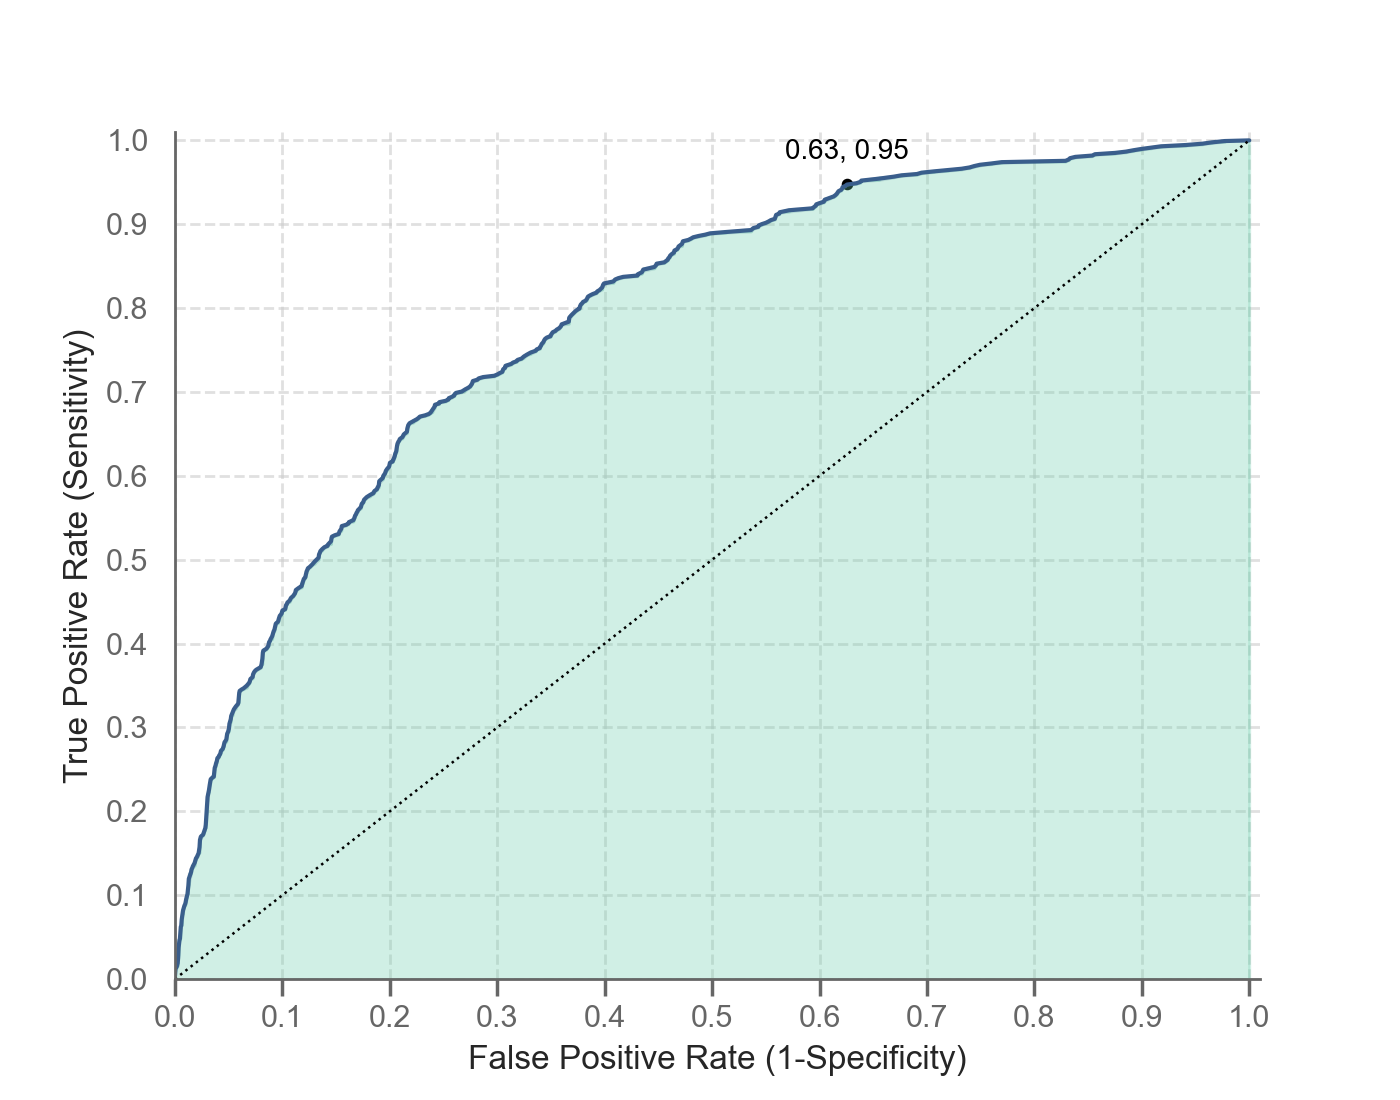

In [208]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

Let's see our chosen model, M4's holdout expected loss

In [209]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["default"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["default"])
round(expected_loss_holdout, 3)

0.642

CM on holdout

In [210]:
cm_object3 = confusion_matrix(data_holdout["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no defaul", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actul no defaul,1223,1795
Actual default,65,725


# PREDICTION WITH RANDOM FOREST

In [211]:
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("default~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 700x550 with 0 Axes>

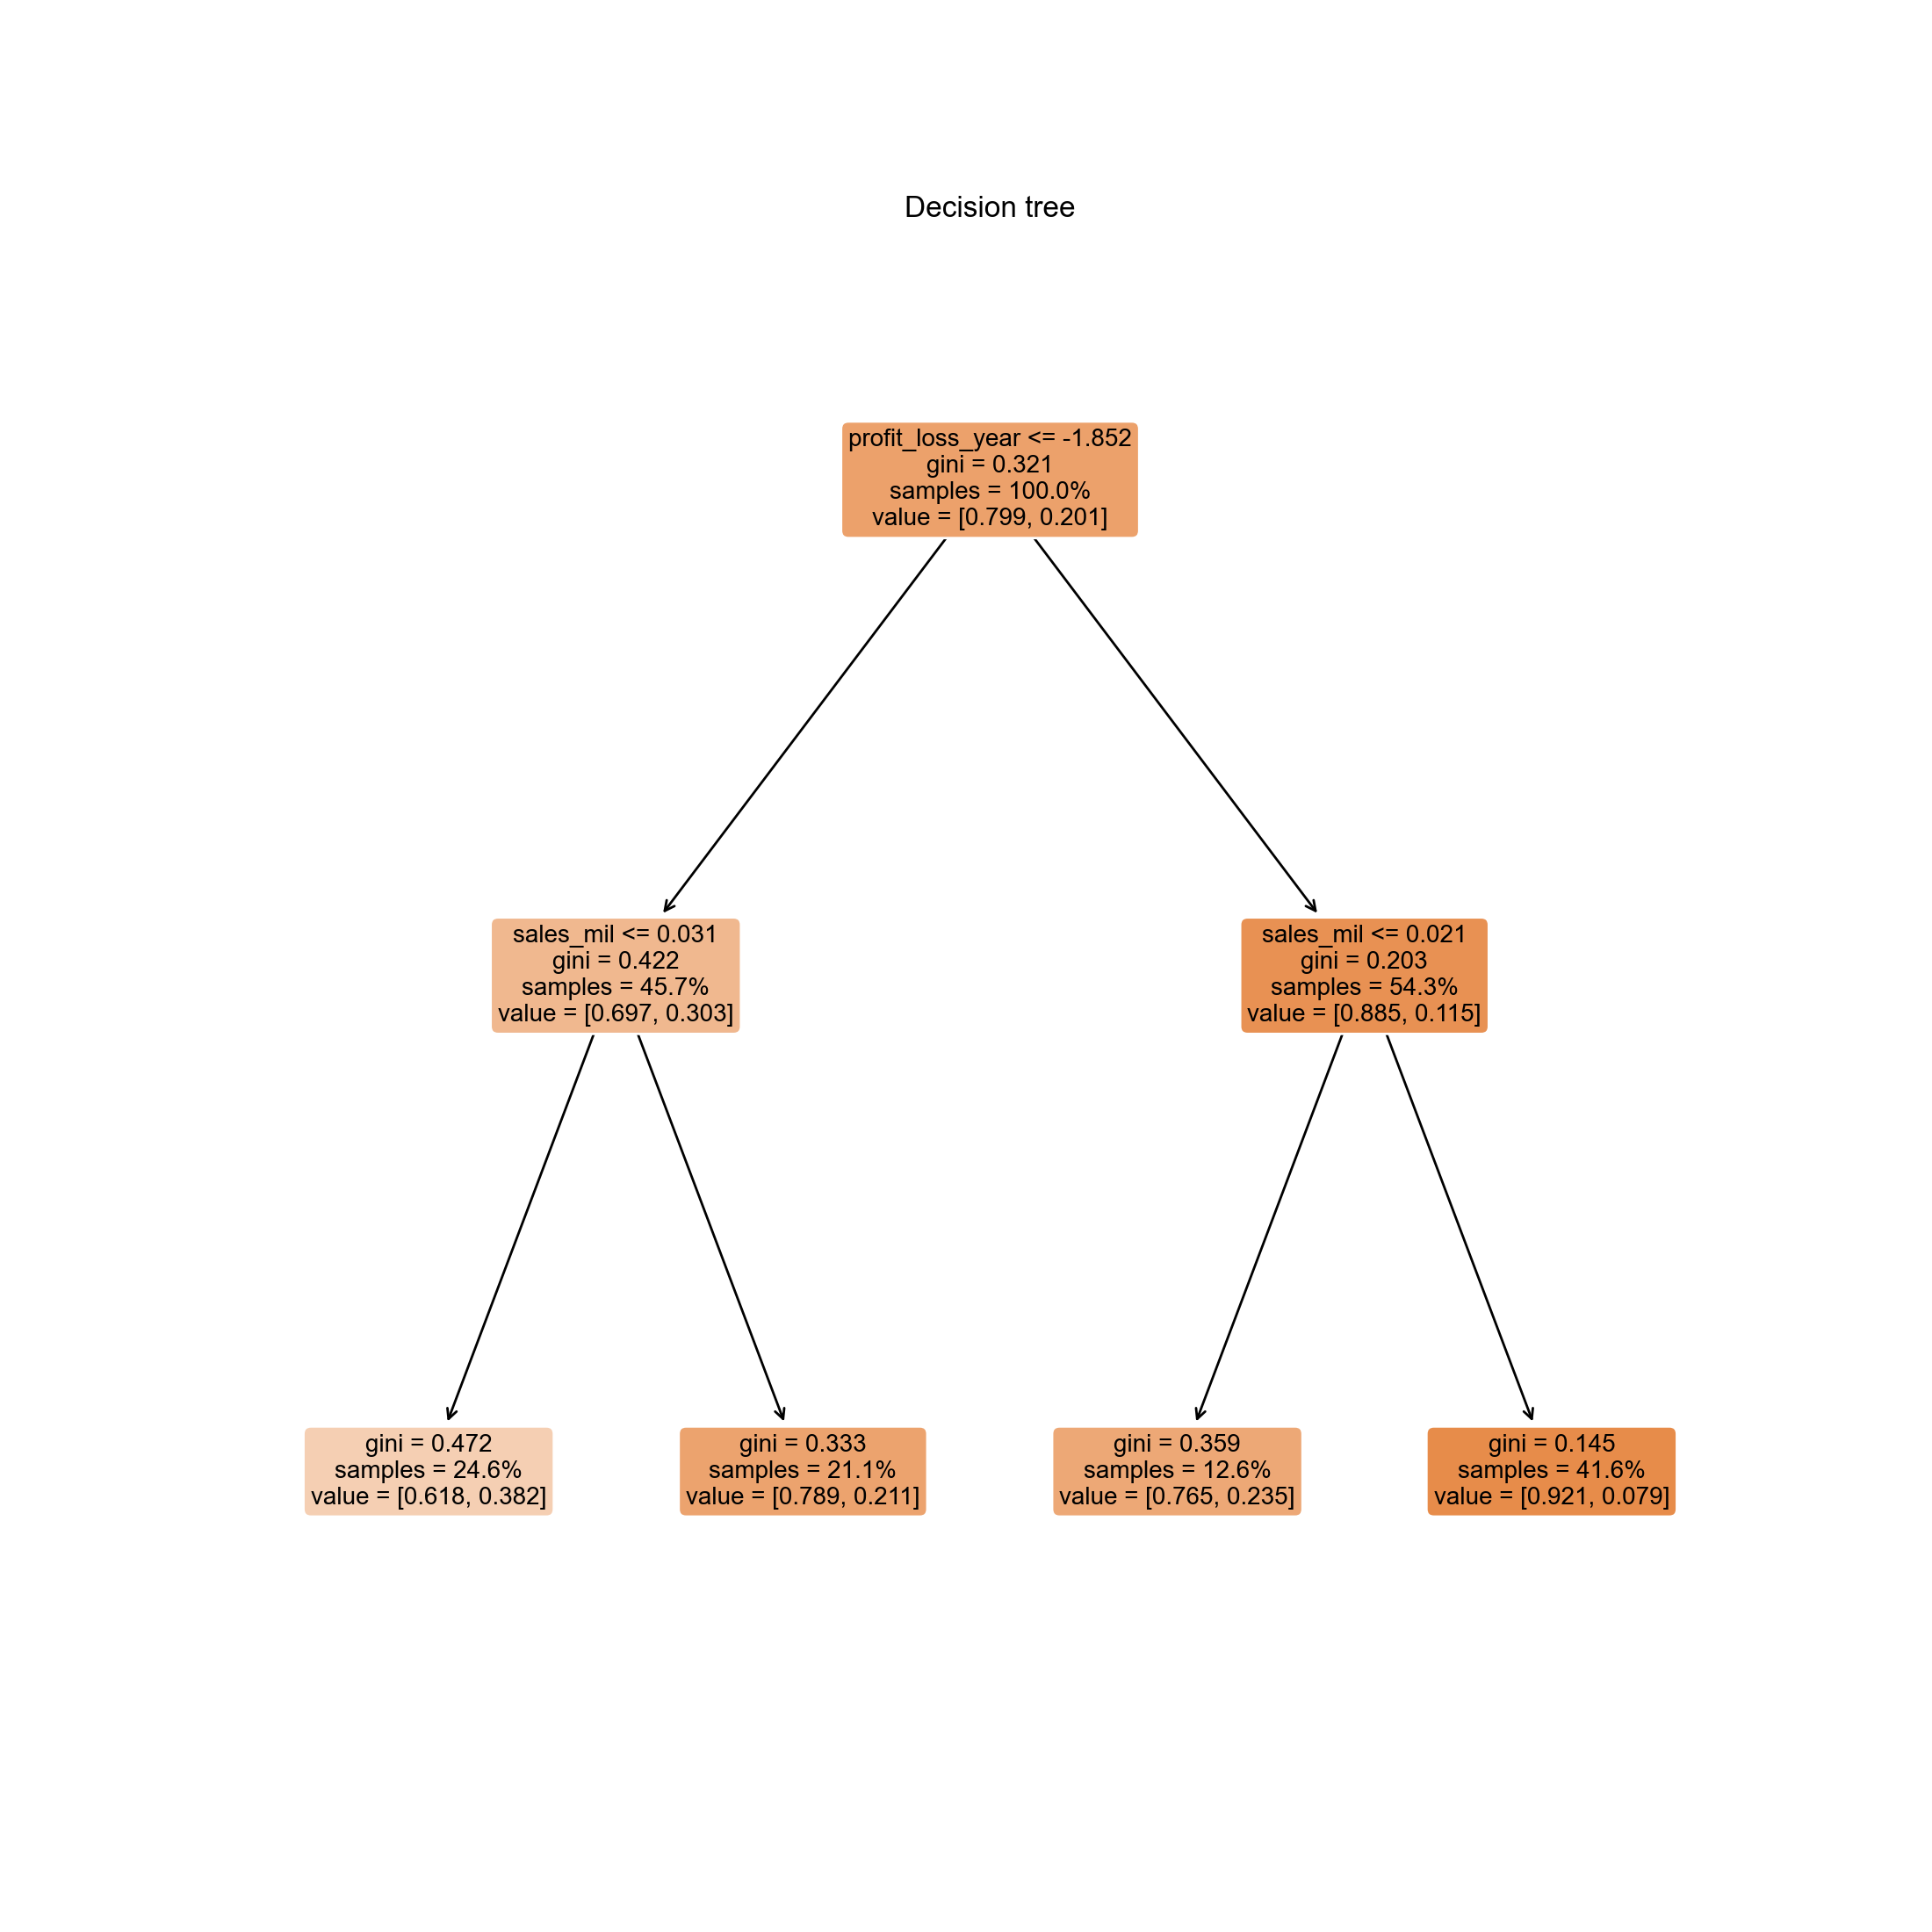

In [212]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [213]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [214]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [215]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [216]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.809347,0.354488
1,5,16,0.809468,0.354360
2,6,11,0.808785,0.354341
3,6,16,0.809254,0.354457
4,7,11,0.807888,0.354472
5,7,16,0.808179,0.354549


Obtain optimal parameter values

In [217]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [218]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [219]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.374277,0.735936
M2,19.0,0.365911,0.770388
M3,36.0,0.364306,0.779135
M4,80.0,0.361587,0.785233
M5,154.0,0.361677,0.784765
LASSO,70.0,0.361086,0.786035
RF,n.a.,0.354360,0.809468


Extract fold level RMSE and AUC

In [220]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [221]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.372357,0.363849,0.361092,0.358717,0.358719,0.358821,0.349121
1,0.370867,0.363950,0.363286,0.360545,0.361303,0.360086,0.352613
2,0.373981,0.367897,0.368342,0.365429,0.366291,0.364990,0.357517
3,0.375318,0.364260,0.361899,0.358025,0.356924,0.357450,0.355466
4,0.378864,0.369600,0.366909,0.365220,0.365146,0.364083,0.356919


In [222]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.742458,0.775183,0.785943,0.791799,0.791295,0.790649,0.819418
1,0.725542,0.758135,0.765490,0.775008,0.774400,0.775266,0.804269
2,0.734218,0.765159,0.769486,0.771067,0.771111,0.773223,0.799163
3,0.733727,0.776729,0.786878,0.797002,0.797873,0.797802,0.810345
4,0.743737,0.776735,0.787879,0.791289,0.789146,0.793235,0.814148


Now use loss function and search for best thresholds and expected loss over folds 

In [223]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [224]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [225]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.354,0.809,0.127,0.138,0.58,0.569


Create plots based on Fold5 in CV 

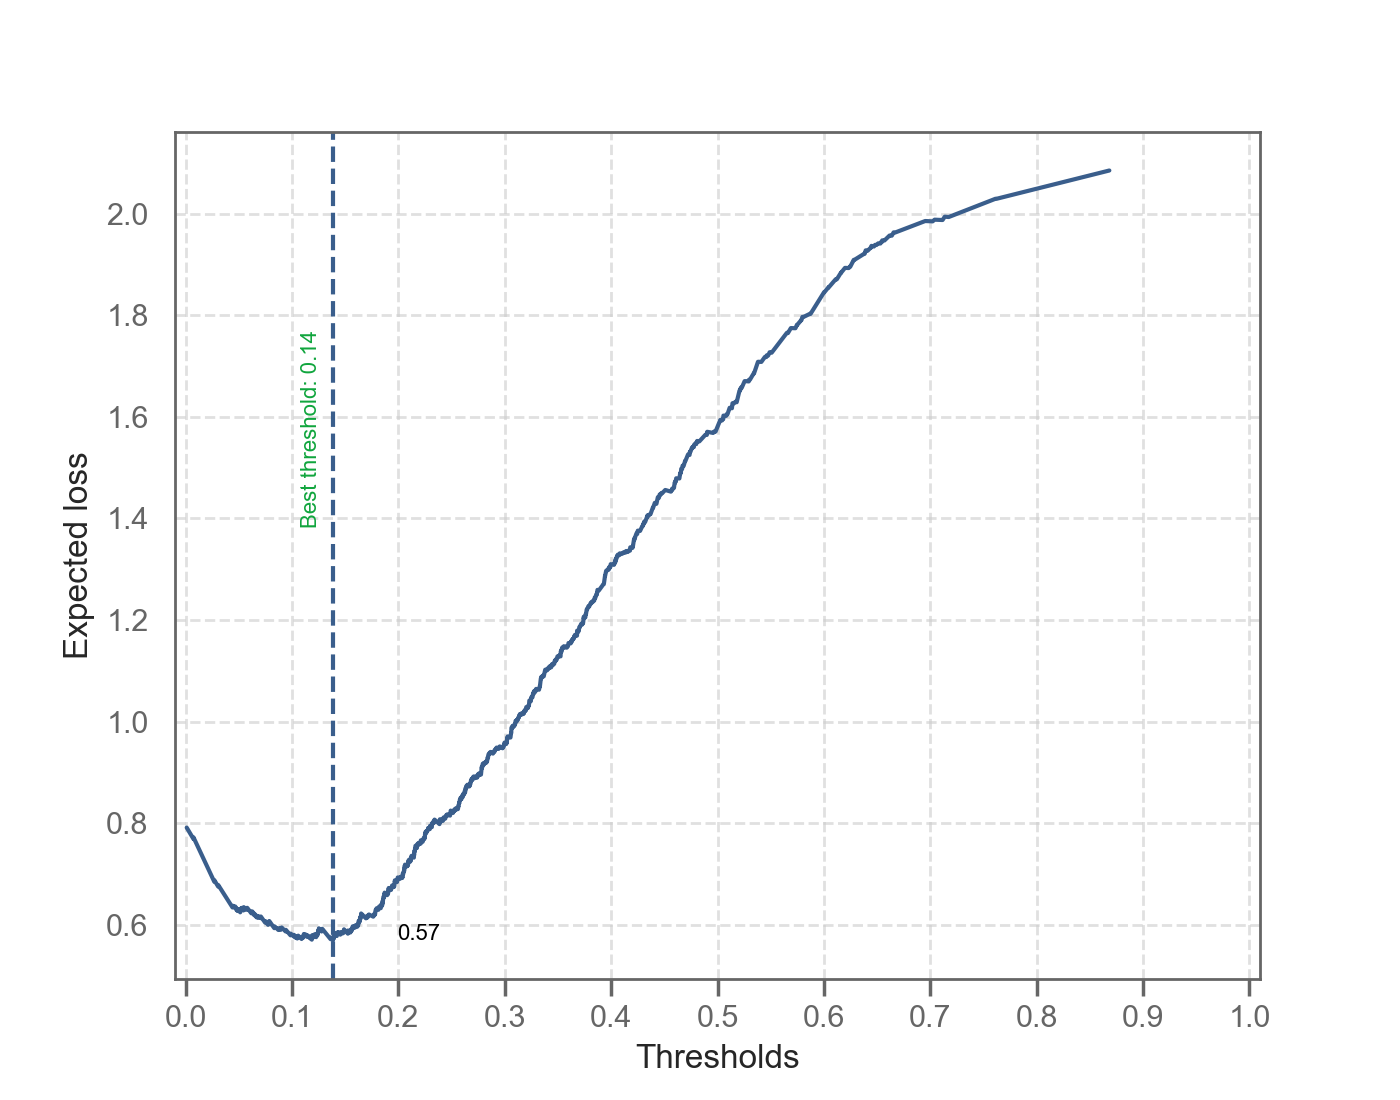

In [226]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

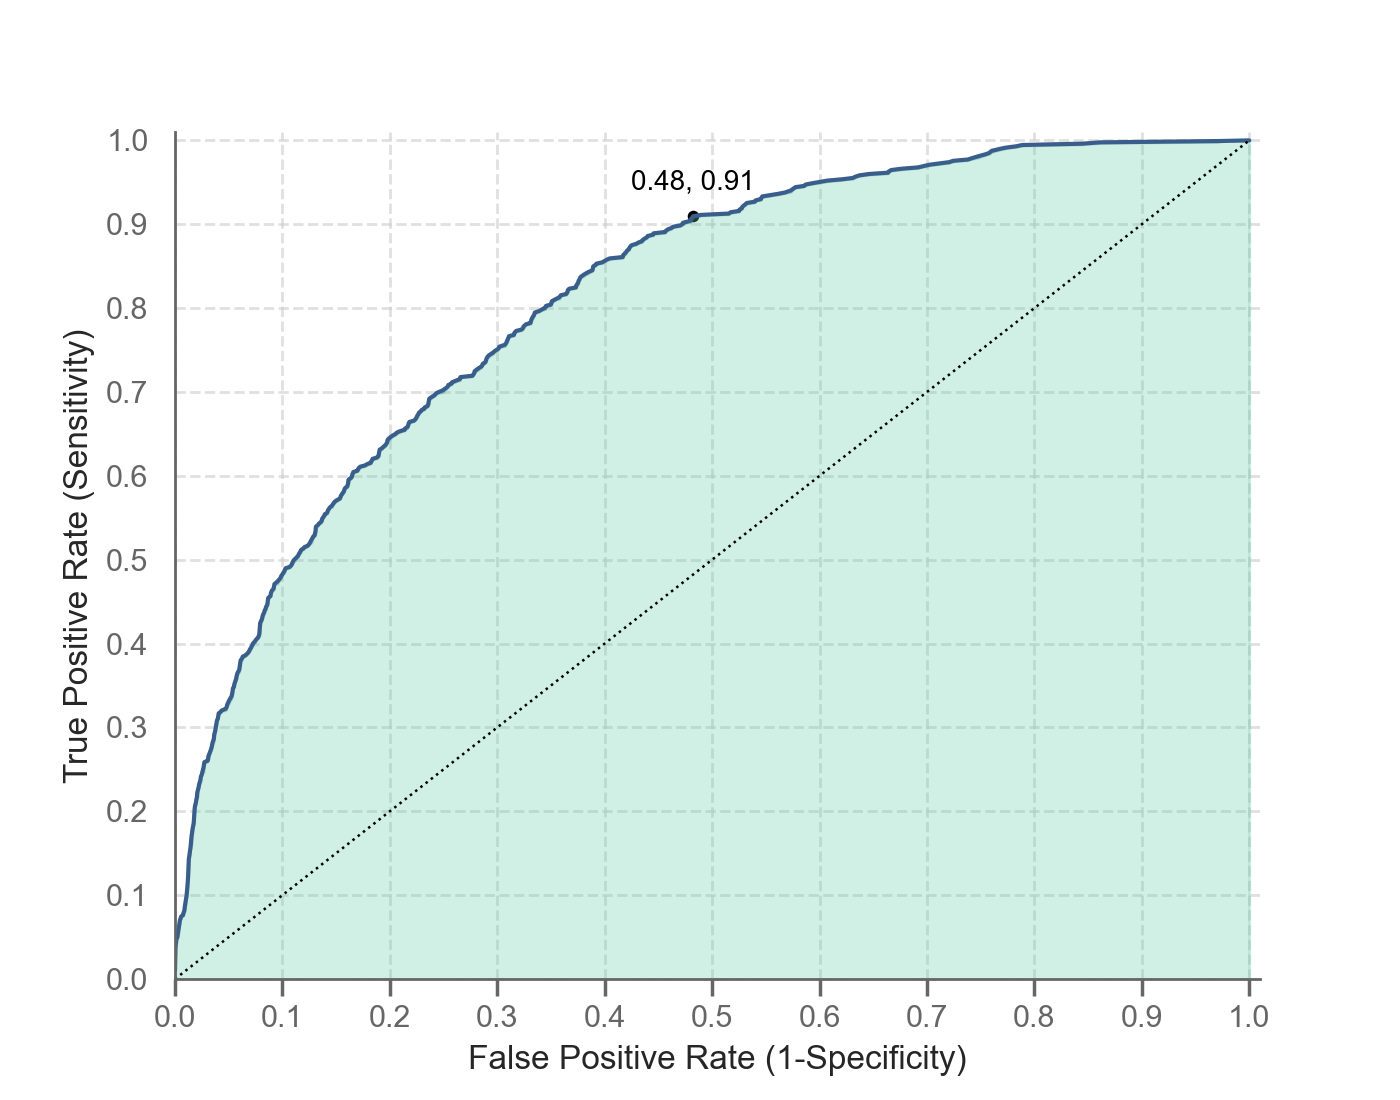

In [227]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [228]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.357

ROC AUC  on holdout

In [229]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.808

 Get expected loss on holdout

In [230]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.618

## Final results

In [231]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [232]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.374277,0.735936,0.086296,0.726753
M2,19.0,0.365911,0.770388,0.093710,0.657998
M3,36.0,0.364306,0.779135,0.084222,0.630351
M4,80.0,0.361587,0.785233,0.088410,0.622602
M5,154.0,0.361677,0.784765,0.094016,0.624835
LASSO,70.0,0.361086,0.786035,0.095320,0.620698
RF,n.a.,0.354360,0.809468,0.126732,0.580113
